In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from scipy import stats
from theano import tensor as tt

from numpy.random import default_rng

In [2]:
%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))
RANDOM_SEED = 54321
np.random.seed(RANDOM_SEED)
rng = default_rng(RANDOM_SEED)
az.style.use('arviz-darkgrid')
az.rcParams["stats.hdi_prob"] = 0.89
az.rcParams["stats.ic_scale"] = "deviance"
az.rcParams["stats.information_criterion"] = "waic"

In [16]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

#### Code 15.1

In [3]:
# Simulate a pancake and return randomly ordered sides
def sim_pancake():
    pancake = rng.integers(3)
    sides = np.array([[1, 1], [1, 0], [0, 0]])[pancake]
    return rng.permutation(sides)

# Simulate 10,000 pancakes
pancakes = np.array([sim_pancake() for i in range(10000)])
up = pancakes[:, 0]
down = pancakes[:, 1]

# Compute proportion 1/1 (BB) out of all 1/1 and 1/0
num_11_10 = np.sum(up==1)
num_11 = np.sum((up==1) & (down==1))
num_11 / num_11_10

0.6716538617064295

#### Code 15.2

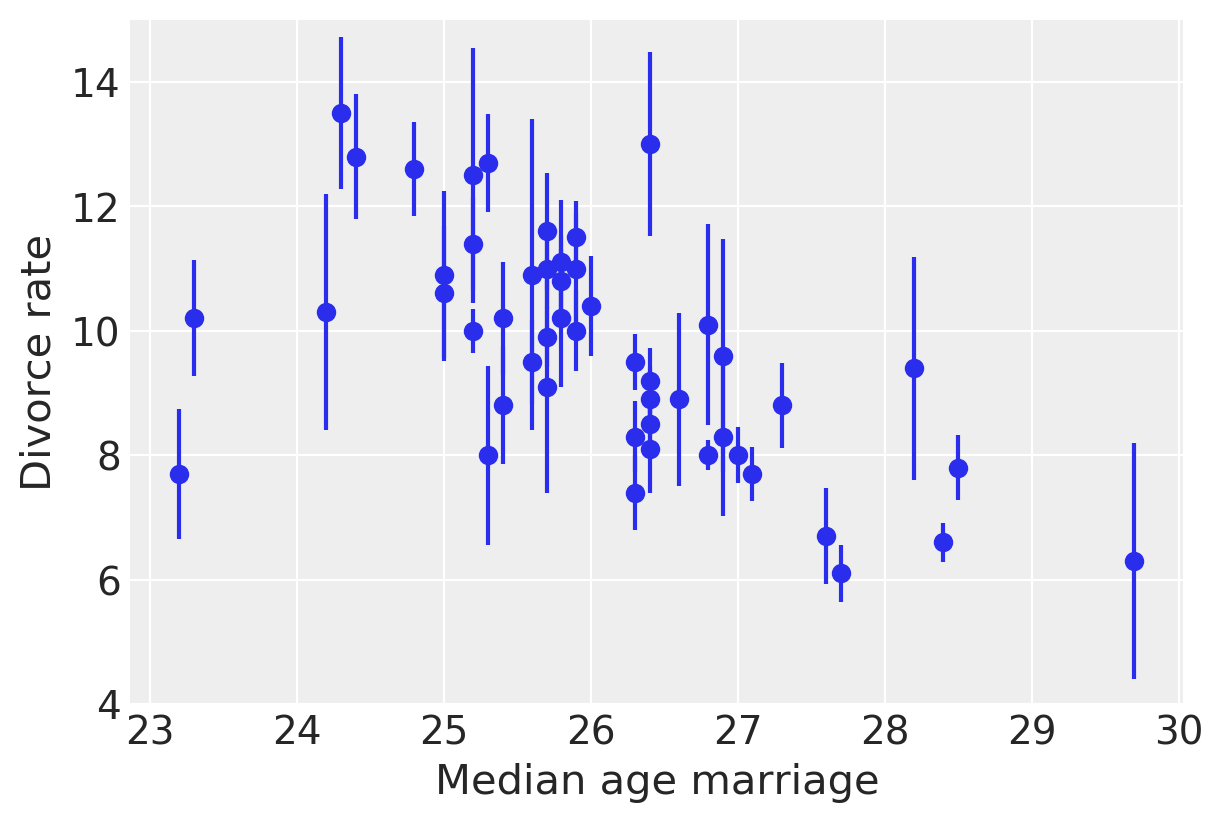

In [11]:
d = pd.read_csv('Data/WaffleDivorce.csv', ';')

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(d['MedianAgeMarriage'], d['Divorce'])
ax.errorbar(d['MedianAgeMarriage'] ,d['Divorce'], yerr=d['Divorce SE'], fmt='none')

ax.set_ylim(4, 15)
ax.set_xlabel('Median age marriage')
ax.set_ylabel('Divorce rate');

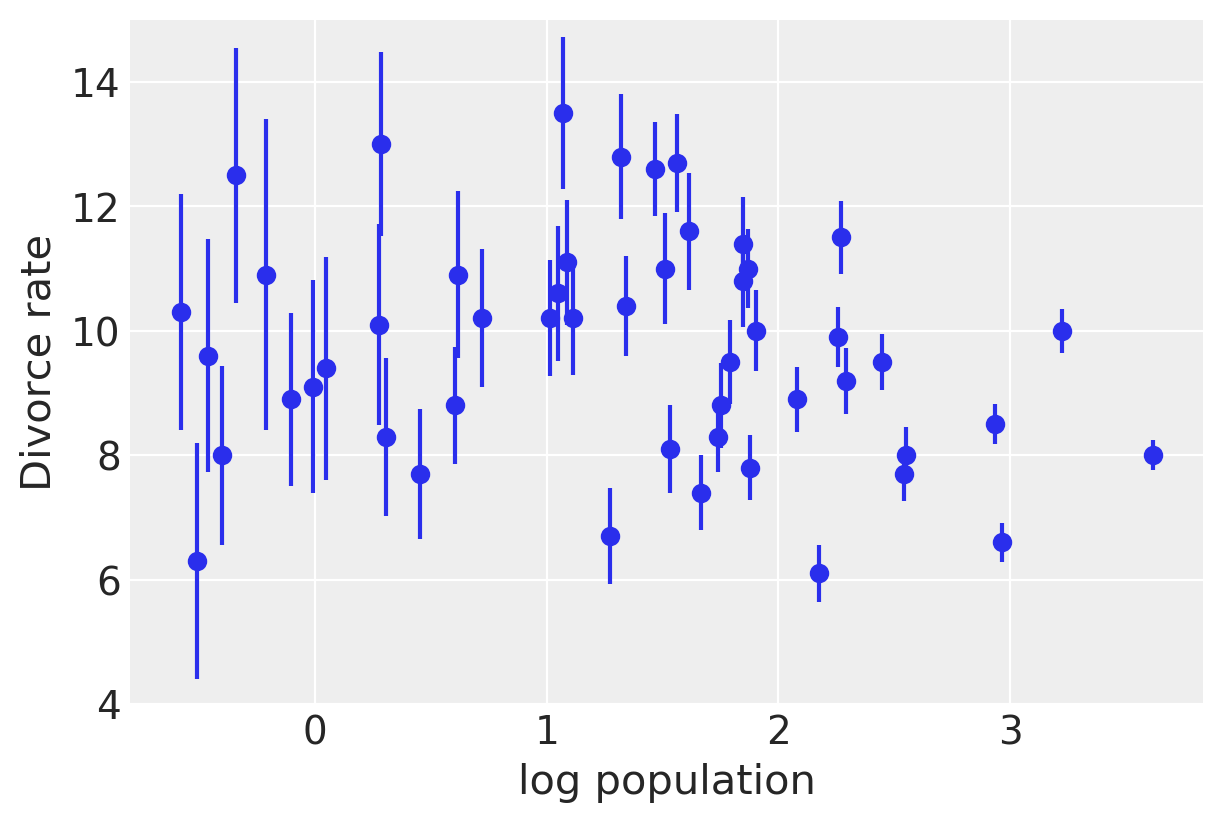

In [15]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(np.log(d['Population']), d['Divorce'])
ax.errorbar(np.log(d['Population']) ,d['Divorce'], yerr=d['Divorce SE'], fmt='none')

ax.set_ylim(4, 15)
ax.set_xlabel('log population')
ax.set_ylabel('Divorce rate');

#### Code 15.3

In [19]:
D_obs = standardize(d['Divorce'])
D_sd = d['Divorce SE'] / d['Divorce'].std()
M = standardize(d['Marriage'])
A = standardize(d['MedianAgeMarriage'])
N = len(d)

with pm.Model() as m_15_1:
    sigma = pm.Exponential('sigma', 1)
    bM = pm.Normal('bM', 0, 0.5)
    bA = pm.Normal('bA', 0, 0.5)
    a = pm.Normal('a', 0, 0.2)
    
    mu = a + bA*A + bM*M
    
    D_true = pm.Normal('D_true', mu, sigma, shape=N)
    D_obs = pm.Normal('D_obs', D_true, D_sd, observed=D_obs)
    
    idata_m15_1 = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [D_true, a, bA, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


#### Code 15.4

In [22]:
az.summary(idata_m15_1, var_names=['~D_true'], round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bM,0.06,0.17,-0.22,0.31,0.0,0.0,1729.90,1729.90,1730.62,2488.08,1.0
bA,-0.61,0.16,-0.87,-0.36,0.0,0.0,1964.11,1964.11,1966.70,2483.38,1.0
a,-0.05,0.09,-0.20,0.09,0.0,0.0,2323.14,2323.14,2330.98,3033.06,1.0
sigma,0.59,0.11,0.43,0.76,0.0,0.0,1074.84,1074.84,1016.45,1164.38,1.0
